In [1]:
import numpy as np
import os
import six
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO, BytesIO
from PIL import Image

import matplotlib.image as mpimg

import pandas as pd
import pickle

import sys
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util

In [2]:
# for fname in os.listdir('images'): 
    
#     if fname.split('.')[-1] in ['jpg', 'png', 'jpeg']:
#         image = Image.open(os.path.join('images', fname))    # Open image as PIL image object
#         image_resized = image.resize((800,600)) # Use PIL to resize      
#         fname_png = os.path.splitext(fname)[0]+'.png' 
#         image_resized.save(os.path.join('images_uniform', fname_png)) #Save image as png
#         image = Image.open(os.path.join('images_uniform', fname_png))
#         assert image.format == 'PNG', "Image format is not PNG!"
#         assert image.size == (800, 600), "Image (w, h) is not (800, 600)!"

In [3]:
def create_record(row): 
    height = 600
    width = 800
    
    filename = row['filename'].encode()
    
    with tf.gfile.GFile(os.path.join('images_uniform', row['filename']), 'rb') as fid:
        encoded_image_data = fid.read()    

    encoded_image_io = BytesIO(encoded_image_data)
    image = Image.open(encoded_image_io)
    image_format = image.format.encode()
    xmins = [ float(i) for i in row['xmins'] ] 
    xmaxs = [ float(i) for i in row['xmaxs'] ]
    ymins = [ float(i) for i in row['ymins'] ]
    ymaxs = [ float(i) for i in row['ymaxs'] ]
    classes_text = [ i for i in row['classes_text'] ] 
    classes = [ int(i) for i in row['classes'] ]
    
    assert image.format == 'PNG', "Image format is not PNG!"
    assert image.size == (800, 600), "Image (w, h) is not (800, 600)!"

    tf_record = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
        
    return tf_record

### Creates train and test `tf.record`

In [4]:
for pickleFile in ['train_extra.p', 'train.p', 'test.p']: 
    
    with open(os.path.join('data', pickleFile), 'rb') as f:
        df = pickle.load(f)
    
    recordFile = (pickleFile[:-2]+'.record').encode()
    
    print("Writing {} ...".format(recordFile))
    
    writer = tf.python_io.TFRecordWriter(recordFile)

    for i in range(df.shape[0]):

        row = df.iloc[i, ]        
        record = create_record(row)
        writer.write(record.SerializeToString())

    writer.close()
    
    print("Finished writing {}.".format(recordFile))

Writing b'train_extra.record' ...
Finished writing b'train_extra.record'.
Writing b'train.record' ...
Finished writing b'train.record'.
Writing b'test.record' ...
Finished writing b'test.record'.


### Eyeballing the image, its xmins, xmaxs, ymins, ymaxs

In [5]:
df.head()

,filename,xmins,xmaxs,ymins,ymaxs,classes,classes_text,height,width,class_text
192,site_1507478254.902404069.png,[0.467687249184],[0.495300710201],[0.344213575125],[0.453657537699],[3],[b'green'],1096,1368,b'green'
186,site_1507478176.931401014.png,[0.595603168011],[0.61523014307],[0.359343379736],[0.434265553951],[3],[b'green'],1096,1368,b'green'
159,site_1507478252.594393014.png,[0.711354732513],[0.731728136539],[0.364539712667],[0.444752961397],[3],[b'green'],1096,1368,b'green'
130,site_1507478079.17502069.png,[0.357760488987],[0.399890065193],[0.335159927607],[0.46424639225],[3],[b'green'],1096,1368,b'green'
76,site_1507478208.910413980.png,[0.451471209526],[0.491333693266],[0.326582223177],[0.461121082306],[1],[b'red'],1096,1368,b'red'


In [6]:
image1 = Image.open(os.path.join('images_uniform', 'site_1507478254.902404069.png'))

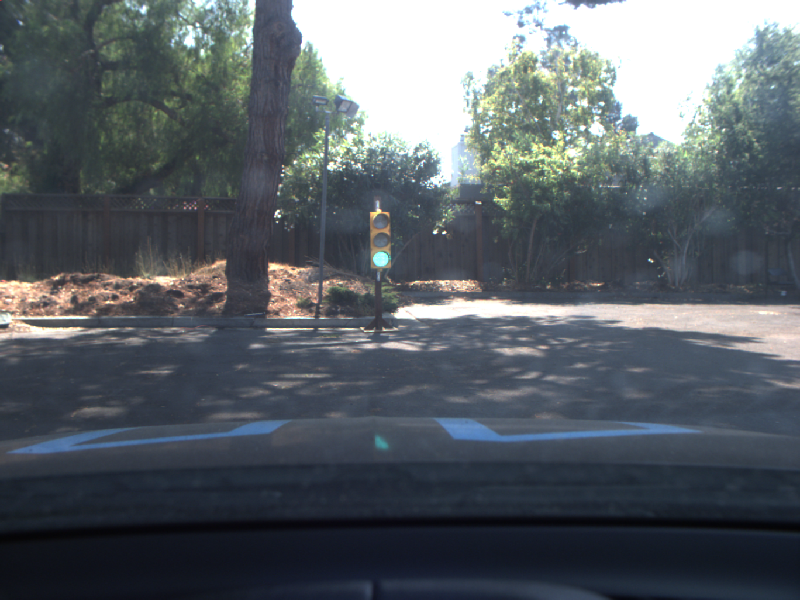

In [7]:
image1

### Check record

In [8]:
class checkProto(tf.test.TestCase):
    def _assertProtoEqual(self, proto_field, expectation):
        proto_list = [p for p in proto_field]
        self.assertListEqual(proto_list, expectation)

In [9]:
example = create_record(df.iloc[0,])

print(example.features.feature['image/object/bbox/ymin'])

float_list {
  value: 0.3442135751247406
}



In [11]:
unk = checkProto()
unk._assertProtoEqual(example.features.feature['image/object/bbox/ymin'].float_list.value, 
                      df.iloc[0,3].tolist())